# DL6

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.init as init

In [2]:
tr=pd.read_csv('train.csv')
tst=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

# 전처리

In [3]:
tr['preferred_difficulty_level'] = tr['preferred_difficulty_level'].replace({'Low':1, 'Medium':2, 'High':3})
tr['subscription_type'] = tr['subscription_type'].replace({'Basic':1, 'Premium':2})

tst['preferred_difficulty_level'] = tst['preferred_difficulty_level'].replace({'Low':1, 'Medium':2, 'High':3})
tst['subscription_type'] = tst['subscription_type'].replace({'Basic':1, 'Premium':2})

# Train, Validation

In [4]:
# train, validation 분할
train, validation = train_test_split(tr, test_size=0.2, random_state=42)

In [5]:
# train 데이터와 validation 데이터를 numpy 배열로 생성
train_X = np.array(train.drop(['user_id', 'target'], axis=1))
train_y = np.array(train['target'])
validation_X = np.array(validation.drop(['user_id', 'target'], axis=1))
validation_y = np.array(validation['target'])

# PyTorch 텐서로 변환
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.int64)
validation_X = torch.tensor(validation_X, dtype=torch.float32)
validation_y = torch.tensor(validation_y, dtype=torch.int64)

In [66]:
import torch.nn.init as init

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(13, 64)
        self.bn1 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)  # 배치 정규화 적용
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)  # 배치 정규화 적용
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid 활성화 함수 적용
        return x

model = BinaryClassifier()

# 하이퍼파라미터 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.99 ** epoch)
num_epochs = 140

Epoch [14/140], Train Loss: 0.6895, Train Accuracy: 0.4820, Validation Loss: 0.6938, Validation Accuracy: 0.4795
Epoch [28/140], Train Loss: 0.6807, Train Accuracy: 0.4881, Validation Loss: 0.6855, Validation Accuracy: 0.4700
Epoch [42/140], Train Loss: 0.6748, Train Accuracy: 0.5199, Validation Loss: 0.6825, Validation Accuracy: 0.4830
Epoch [56/140], Train Loss: 0.6690, Train Accuracy: 0.5411, Validation Loss: 0.6788, Validation Accuracy: 0.4900
Epoch [70/140], Train Loss: 0.6631, Train Accuracy: 0.5675, Validation Loss: 0.6758, Validation Accuracy: 0.5040
Epoch [84/140], Train Loss: 0.6567, Train Accuracy: 0.5913, Validation Loss: 0.6729, Validation Accuracy: 0.5185
Epoch [98/140], Train Loss: 0.6503, Train Accuracy: 0.6099, Validation Loss: 0.6697, Validation Accuracy: 0.5445
Epoch [112/140], Train Loss: 0.6441, Train Accuracy: 0.6205, Validation Loss: 0.6669, Validation Accuracy: 0.5565
Epoch [126/140], Train Loss: 0.6381, Train Accuracy: 0.6309, Validation Loss: 0.6645, Validatio

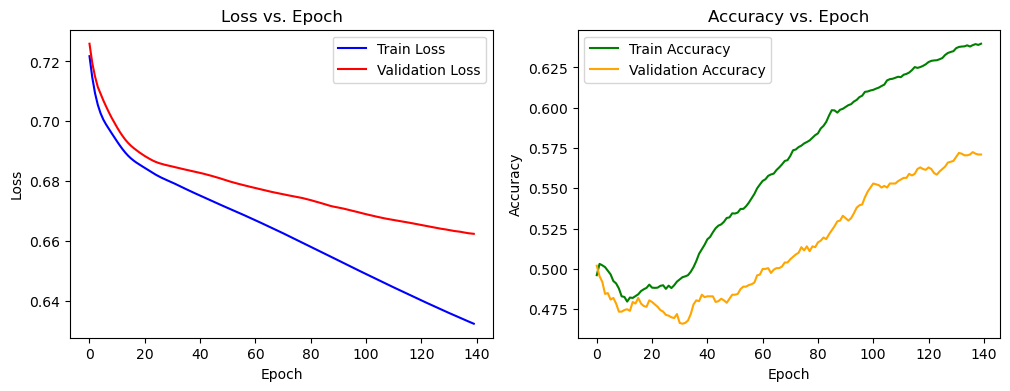

In [67]:
# 모델 학습
train_losses = []  # 훈련 손실 저장
train_accuracies = []  # 훈련 정확도 저장
validation_losses = []  # 검증 손실 저장
validation_accuracies = []  # 검증 정확도 저장

for epoch in range(num_epochs):
    # 훈련 데이터에 대한 forward 및 역전파
    optimizer.zero_grad()
    train_outputs = model(train_X)
    train_loss = criterion(train_outputs, train_y.float().view(-1, 1))
    train_loss.backward()
    optimizer.step()
    
    # 훈련 데이터 정확도 계산
    train_predicted = (train_outputs > 0.5).float()
    train_accuracy = accuracy_score(train_y, train_predicted)
    
    # 검증 데이터에 대한 forward
    with torch.no_grad():
        validation_outputs = model(validation_X)
        validation_loss = criterion(validation_outputs, validation_y.float().view(-1, 1))
    
    # 검증 데이터 정확도 계산
    validation_predicted = (validation_outputs > 0.5).float()
    validation_accuracy = accuracy_score(validation_y, validation_predicted)
    
    # 손실과 정확도 저장
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy)
    validation_losses.append(validation_loss.item())
    validation_accuracies.append(validation_accuracy)
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {validation_loss.item():.4f}, Validation Accuracy: {validation_accuracy:.4f}')

# 손실과 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(validation_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Retrain

In [8]:
X = np.array(tr.drop(['user_id', 'target'], axis=1))  # 'target' 열을 제외한 모든 열을 특성으로 사용
y = np.array(tr['target'])
X_test = np.array(tst.drop('user_id', axis=1))

# PyTorch 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

In [68]:
import torch.nn.init as init

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(13, 64)
        self.bn1 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)  # 배치 정규화 적용
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)  # 배치 정규화 적용
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid 활성화 함수 적용
        return x

model = BinaryClassifier()

# 하이퍼파라미터 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.99 ** epoch)
num_epochs = 140

Epoch [14/140], Loss: 0.6712, Accuracy: 0.5515
Epoch [28/140], Loss: 0.6639, Accuracy: 0.5693
Epoch [42/140], Loss: 0.6585, Accuracy: 0.5915
Epoch [56/140], Loss: 0.6541, Accuracy: 0.6110
Epoch [70/140], Loss: 0.6500, Accuracy: 0.6185
Epoch [84/140], Loss: 0.6460, Accuracy: 0.6238
Epoch [98/140], Loss: 0.6423, Accuracy: 0.6251
Epoch [112/140], Loss: 0.6388, Accuracy: 0.6258
Epoch [126/140], Loss: 0.6356, Accuracy: 0.6287
Epoch [140/140], Loss: 0.6327, Accuracy: 0.6295


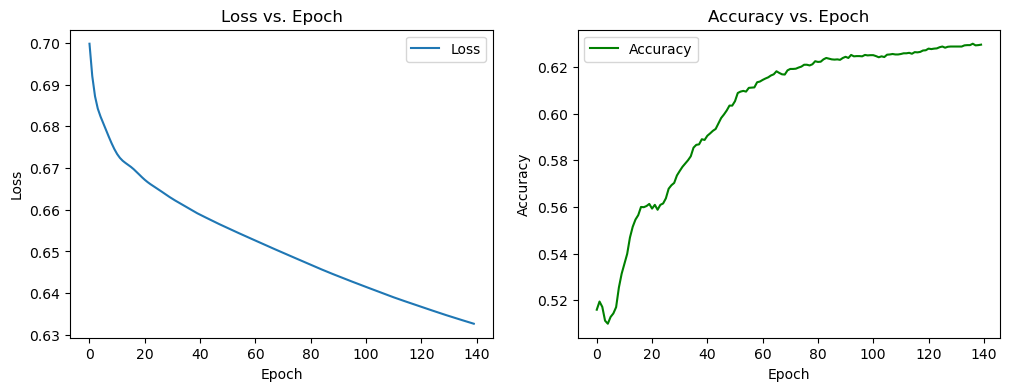

In [69]:
# 모델 학습
losses = []  # 손실 저장
accuracies = []  # 정확도 저장
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y.float().view(-1, 1))
    loss.backward()
    optimizer.step()
    
    # 정확도 계산
    predicted = (outputs > 0.5).float()
    accuracy = accuracy_score(y, predicted)
    
    losses.append(loss.item())
    accuracies.append(accuracy)
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# 손실과 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Prediction

In [79]:
# 모델을 평가 모드로 설정
model.eval()

# PyTorch 텐서로 변환
X_test = torch.tensor(X_test, dtype=torch.float32)

# 예측 생성
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred >= 0.5683).float()  # 임계값 0.5를 기준으로 이진 분류 결과 생성

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sub=sample.copy()
sub['target'] = y_pred

# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
sub['target']=sub['target'].astype('int')

submit_path = 'submission/DL6.2.csv'
sub.to_csv(submit_path, index=False)

sub['target'].value_counts()

C:\Users\young0tete\AppData\Local\Temp\ipykernel_152668\3143832303.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


1    6197
0    3803
Name: target, dtype: int64

In [27]:
tr['target'].value_counts()

1    6199
0    3801
Name: target, dtype: int64